# Seeded Watershed für membranbasierte Zellsegmentierung
In diesem Abschnitt werden wir einen Seeded-Watershed-Ansatz zur Zellsegmentierung verwenden. Dieser Ansatz ist sehr verbreitet, wenn die Zellsegmentierung auf Bildern von Membranmarkern basiert. Daher verwenden wir das napari-Plugin [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes). Im Hintergrund verwendet dieses Plugin Funktionen von [scikit-image](http://scikit-image.org/).

Siehe auch
* [Robert Haases Vorlesung 02a Bildfilterung und Segmentierung, Watershed-Erklärung bei 35:30](https://youtu.be/LT8L3vSLQ2Q?t=2124)

In [1]:
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling, \
                                                           seeded_watershed, \
                                                           local_minima_seeded_watershed
from skimage.io import imread
from skimage.filters import gaussian
from skimage import data
from pyclesperanto_prototype import imshow

Wir laden das Cells3d-Beispielbild aus scikit-image, das ein zweikanaliges Bild ist, das Zellkerne und Membranen zeigt.

In [2]:
cells = data.cells3d()
cells.shape

(60, 2, 256, 256)

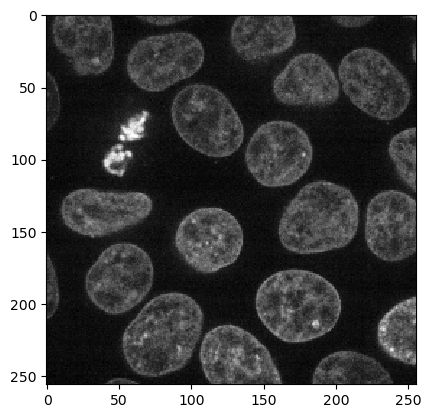

In [3]:
nuclei_channel = cells[30, 1]

imshow(nuclei_channel)

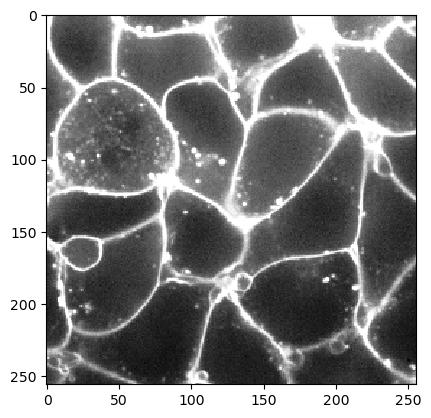

In [4]:
membrane_channel = cells[30, 0]

imshow(membrane_channel, max_display_intensity=6000)

## Voronoi-Otsu-Labeling für Zellkernsegmentierung
Zunächst beginnen wir mit der Segmentierung der Zellkerne unter Verwendung des [Voronoi-Otsu-Labeling-Algorithmus](image-segmentation:voronoi-otsu-labeling).

StackViewNDArray([[0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  [0, 0, 0, ..., 5, 5, 5],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]])
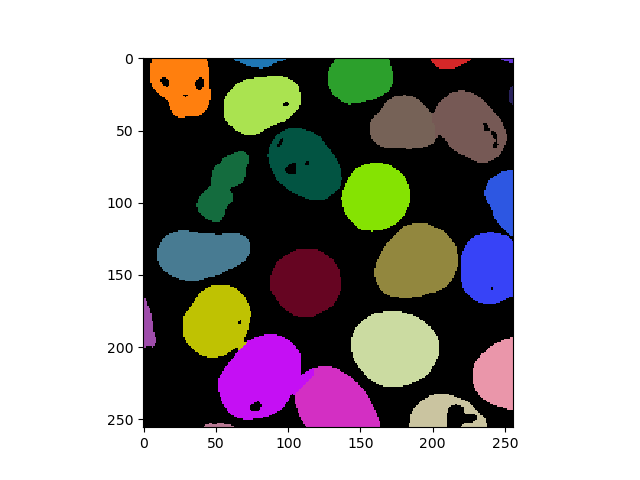

In [5]:
labeled_nuclei = voronoi_otsu_labeling(nuclei_channel, spot_sigma=10, outline_sigma=2)
labeled_nuclei

## Seeded Watershed
Wir können das Bild der markierten Zellkerne als Ausgangspunkt für die Flutung der Bereiche mit niedriger Intensität im Membranbild verwenden. Dies ermöglicht uns, eine Zellsegmentierung zu bestimmen.

StackViewNDArray([[ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  ...,
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25]])
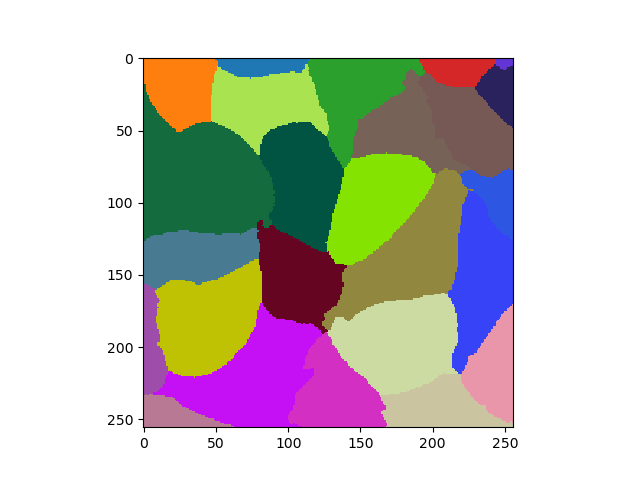

In [6]:
labeled_cells = seeded_watershed(membrane_channel, labeled_nuclei)
labeled_cells

Wenn die Umrisse der Zellen nicht zu 100% genau sind, kann es sinnvoll sein, das Membranbild vor der Segmentierung der Zellen etwas zu verwischen.

StackViewNDArray([[ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  [ 1,  1,  1, ...,  5,  5,  5],
                  ...,
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25],
                  [24, 24, 24, ..., 25, 25, 25]])
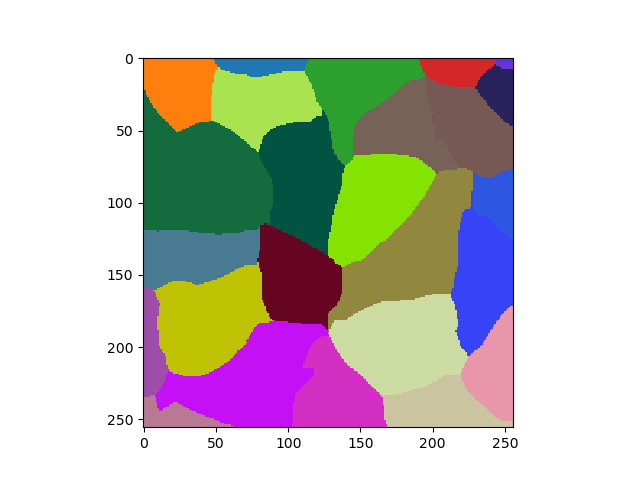

In [7]:
blurred = gaussian(membrane_channel, sigma=3)

labeled_cells = seeded_watershed(blurred, labeled_nuclei)
labeled_cells

## Seeded Watershed mit automatischer Keimpunktdetektion

Falls wir keinen separaten Zellkernkanal aufgenommen haben und nur den Membrankanal für die Segmentierung zur Verfügung haben, können wir das Membranbild verwenden, um nach lokalen Minima (dunkle Bereiche) zu suchen.

StackViewNDArray([[ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  ...,
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27]])
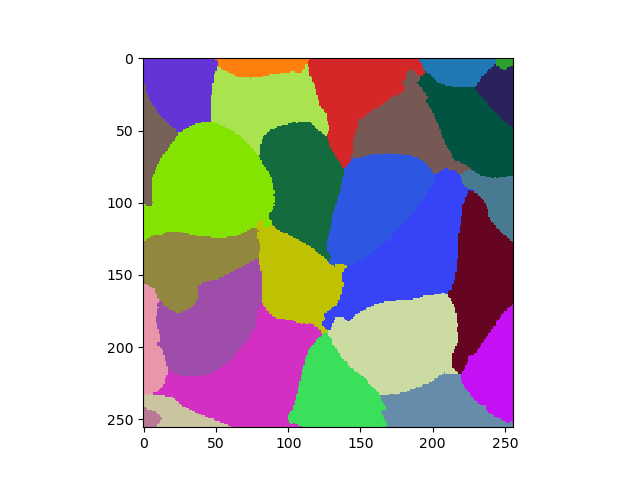

In [8]:
labeles_cells2 = local_minima_seeded_watershed(membrane_channel)
labeles_cells2

Diese Funktion verfügt auch über einige Parameter, die eine Feinabstimmung der Segmentierung ermöglichen. Der Parameter `outline_sigma` ermöglicht die Steuerung eines Gauß'schen Weichzeichnungsfilters, der eine Feinabstimmung der Umrisse der segmentierten Zellen ermöglicht, wie oben gezeigt.

StackViewNDArray([[ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  ...,
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27],
                  [24, 24, 24, ..., 27, 27, 27]])
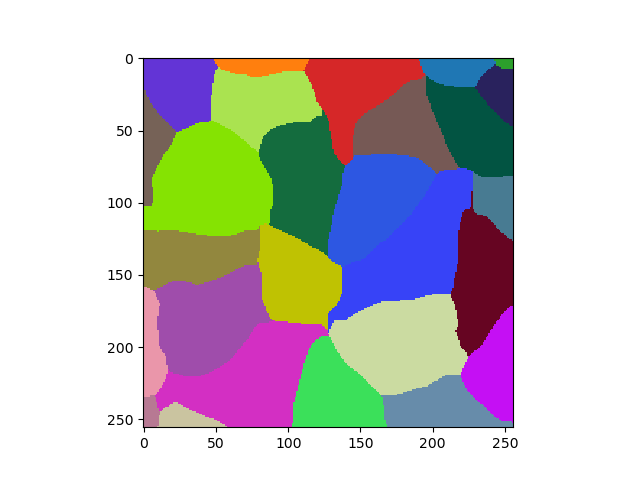

In [9]:
labeles_cells3 = local_minima_seeded_watershed(
                      membrane_channel, 
                      outline_sigma=3)
labeles_cells3

Wenn mehrere Zellen zusammenkleben, kann es sinnvoll sein, `spot_sigma` festzulegen. Dieser Parameter ermöglicht die Konfiguration, wie nah / groß Zellen sind.

StackViewNDArray([[ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  [ 5,  5,  5, ...,  3,  3,  3],
                  ...,
                  [26, 26, 26, ..., 28, 28, 28],
                  [26, 26, 26, ..., 28, 28, 28],
                  [26, 26, 26, ..., 28, 28, 28]])
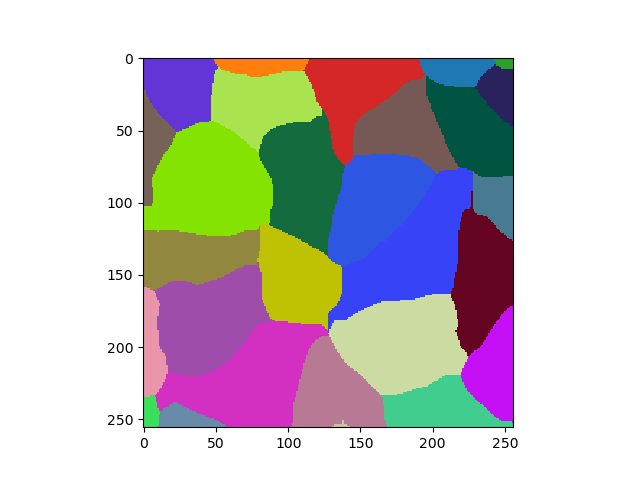

In [10]:
labeles_cells4 = local_minima_seeded_watershed(
                       membrane_channel, 
                       spot_sigma=9, 
                       outline_sigma=3)
labeles_cells4

## Übung
Laden Sie den folgenden Datensatz und finden Sie gute Parameter für die Verarbeitung mit einem Seeded-Watershed-Ansatz. Dieses Beispielbildmaterial wurde freundlicherweise von Sascha M. Kuhn, Nadler Lab, MPI-CBG Dresden zur Verfügung gestellt.

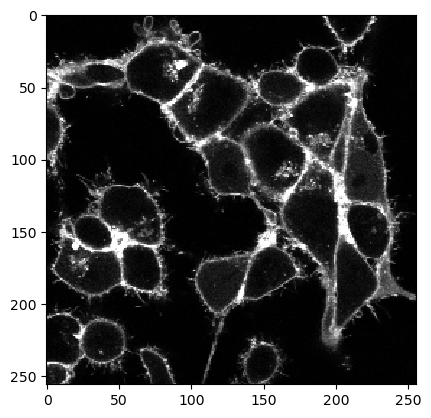

In [11]:
image_slice = imread("../../data/membrane_2d_timelapse.tif")[2]

imshow(image_slice)